In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# 파라미터 튜닝 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
#pd.set_option('display.max_rows', None)
# 대충 돌릴때 체크 : cross-val
from sklearn.model_selection import cross_val_score

# 평가
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
## Kernel Ridge Model
#import optuna
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore")

# 대충 돌릴때 체크 : cross-val
from sklearn.model_selection import cross_val_score

# 평가
from sklearn.metrics import accuracy_score


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from matplotlib import font_manager, rc
# 한글 폰트 지정 
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name() 
#rc('font', family=font_name) 
from imblearn.under_sampling import RandomUnderSampler

In [48]:
data = pd.read_csv('무상증자data2.csv',)

In [49]:
del data['Unnamed: 0']
del data['증자비율']
data=data.dropna()
data=data[data != float('inf')].dropna()
del data['회사명']
del data['code']
del data['Date']
del data['Name']
del data['Industry']
del data['High']
del data['Low']

In [50]:
# 주의!!) scikit learn으로 one hot encoding을 할 때....
# 라벨인코더와 원핫인코더 2개가 필요!!!! -> 2단계!!!!!
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()
result = le.fit_transform(data['Market'])# 코스피 1 코스닥 0
data['Market']=result

result2 = le.fit_transform(data['Sector'])# 코스피 1 코스닥 0
data['Sector']=result2
시장=pd.DataFrame(index=le.inverse_transform(result),data=result ,columns=['Num']).drop_duplicates()
섹터=pd.DataFrame(index=le.inverse_transform(result2),data=result2 ,columns=['Num']).drop_duplicates()


In [51]:
y_무상증자 = data.loc[:,"무상증자여부"]
X_무상증자 = data.drop("무상증자여부", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_무상증자,
                                                    y_무상증자,
                                                    test_size= 0.3,
                                                    random_state=1234,
                                                    stratify=y_무상증자)

## 승일님이 제안한 샘플링 방법

In [221]:
X_train['y_train'] = y_train
X_train_sample = X_train[X_train['y_train'] == 0].sample(n = 200, random_state=1,  replace = True)

X_train_1 = X_train[X_train['y_train'] == 1]

y_train_sample = X_train_sample['y_train']

y_train_1 = X_train_1['y_train']
X_train_sample.drop('y_train', axis = 1, inplace = True)

X_train_1.drop('y_train', axis = 1, inplace = True)
X_train = pd.concat([X_train_sample, X_train_1])
y_train = pd.concat([y_train_sample, y_train_1])
rus = RandomUnderSampler()
# X_train, y_train = rus.fit_resample(X_train, y_train)
X_test2, y_test2 = rus.fit_resample(X_test, y_test)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
X_train2, y_train2 = smote.fit_resample(X_train, y_train)

['OBV', '부채비율성장율', '자본성장율', '베타', '개인', '자산성장율', '소액주주보유주식비율', 'PSR', '유동비율', '유동비율성장율', '영업이익증가율', '역배열', '매출액증가율', '윌리엄R%', '기관합계', 'High', '거래회전율', 'ROA', '영업이익율', 'Sector', 'PBR', '최대주주_특수관계인지분율', 'EBITDA마진율', 'CCI', '자기자본비율', '기업규모(log)', 'OP/A', '볼린저밴드위치', 'Volume', 'PER', '부채비율', 'MFI', '자산회전율성장율', 'RSI', '부채회전율', 'EBITDA증가율', 'Close', '자본회전율', 'EPS증가율', '당기순이익증가율', 'EV/EBITDA', 'Low', 'ROE', '정배열', '자산회전율', '자기주식비율', 'Market', '흑자전환']


#단순 언더샘플링
rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)


In [219]:
from itertools import combinations
from tqdm import tqdm
train_정확도=[]
train_재현율=[]
train_정밀도=[]
train_F1=[]
train_ROC=[]
test_정확도=[]
test_재현율=[]
test_정밀도=[]
test_F1=[]
test_ROC=[]
combo=[]
for i in tqdm(range(len(X_train.columns),len(X_train.columns)+1)):
    조합=[[  'PBR', 
           'RSI', 'EBITDA증가율', 
           'EV/EBITDA', '개인', '자산성장율', '소액주주보유주식비율' ]]
    for k in range(0,len(조합)):

        model=LGBMClassifier( n_jobs= -1,random_state=1234)
        X_train_temp=X_train[list(조합[k])]
        X_test_temp=X_test[list(조합[k])]
        model.fit(X_train_temp, y_train)
        pred = model.predict(X_train_temp)
        train_정확도.append( accuracy_score(y_train, pred))
        train_재현율.append( recall_score(y_train, pred))
        train_정밀도.append( precision_score(y_train, pred))
        train_F1.append( f1_score(y_train, pred))
        train_ROC.append(roc_auc_score(y_train, pred))

        pred = model.predict(X_test_temp)
        test_정확도.append( accuracy_score(y_test, pred))
        test_재현율.append( recall_score(y_test, pred))
        test_정밀도.append(precision_score(y_test, pred))
        test_F1.append( f1_score(y_test, pred))
        test_ROC.append( roc_auc_score(y_test, pred))
        combo.append(list(조합[k]))

100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


In [223]:
df_모든경우의수=pd.DataFrame({'train_정밀도':train_정밀도,  'test_정밀도':test_정밀도,  'train_정확도':train_정확도, 'train_재현율':train_재현율,'train_F1':train_F1,'train_ROC':train_ROC,'test_정확도':test_정확도,'test_F1':test_F1,'test_ROC':test_ROC ,'조합':combo})
df_모든경우의수['일치율']=df_모든경우의수['test_정밀도']/df_모든경우의수['train_정밀도']
df=df_모든경우의수 #[['train_정밀도','test_정밀도','일치율','조합']]
df['조합수']=df['조합'].apply(lambda x: len(x))
df[(df['train_정밀도']>=0.6) & (df['test_정밀도']>=0.6) ].sort_values('일치율', ascending=False)
df.to_csv('피처최적화_이대형.csv',encoding='utf-8-sig', index=False)
df[['train_정밀도','test_정밀도','일치율','조합']]

ValueError: ignored

In [ ]:
조합=[['OBV',  '영업이익증가율', 'Sector','PBR', '최대주주_특수관계인지분율', 'OP/A', 'Volume', 
         'PER', '부채비율', 'MFI', '자산회전율성장율', 'RSI', '부채회전율', 'EBITDA증가율', 'Close', 
         '자본회전율', 'EPS증가율',  'EV/EBITDA', 'ROE', '정배열', '자산회전율', 'Market', '흑자전환','자본성장율', '베타', '개인', '자산성장율', '소액주주보유주식비율', '유동비율', '유동비율성장율']]

In [222]:
from itertools import combinations
from tqdm import tqdm
df=pd.DataFrame()




for i in tqdm(range(100)):
    X_train['y_train'] = y_train
    X_train_sample = X_train[X_train['y_train'] == 0].sample(n = 200, replace = True)
    X_train_1 = X_train[X_train['y_train'] == 1]
    y_train_sample = X_train_sample['y_train']
    y_train_1 = X_train_1['y_train']
    X_train_sample.drop('y_train', axis = 1, inplace = True)
    X_train_1.drop('y_train', axis = 1, inplace = True)
    X_train = pd.concat([X_train_sample, X_train_1])
    y_train = pd.concat([y_train_sample, y_train_1])
    rus = RandomUnderSampler()
    # X_train, y_train = rus.fit_resample(X_train, y_train)
    X_test2, y_test2 = rus.fit_resample(X_test, y_test)
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=1)
    X_train2, y_train2 = smote.fit_resample(X_train, y_train)
    columns=X_train.columns
    for i in range(len(columns),5,-1):
        
        조합=list(combinations(list(columns),i))
        temp=pd.DataFrame()
        train_정밀도=[]
        test_정밀도=[]
        일치율=[]
        조합2=[]
        조합수=[]
        for k in range(0,len(조합)):

            model=LGBMClassifier( n_jobs= -1,random_state=1234)
            X_train_temp=X_train2[list(조합[k])]
            X_test_temp=X_test2[list(조합[k])]
            model.fit(X_train_temp, y_train2)

            pred = model.predict(X_train_temp)
            train=precision_score(y_train2, pred)
            train_정밀도.append(train)


            pred = model.predict(X_test_temp)
            test=precision_score(y_test2, pred)
            test_정밀도.append(test)

            일치율.append(test/train)
            조합2.append(list(조합[k]))
            조합수.append(len(조합[k]))

        temp['train']=train_정밀도
        temp['test']=test_정밀도
        temp['일치율']=일치율
        temp['조합']=조합2
        temp['조합수']=조합수
        temp2=temp.sort_values(by=["일치율","test"], ascending=[False, False]) 
        temp_columns=columns
        for i in range(0,len(temp2)-1):
            new_columns.extend(temp2.iloc[i,3])
        제거할피처=set(temp_columns)-set(temp2.iloc[-1,3])
        new_columns=list(set(temp_columns)-제거할피처)
        columns=new_columns

        df=df.append(temp)

100%|██████████| 100/100 [1:46:53<00:00, 64.13s/it]


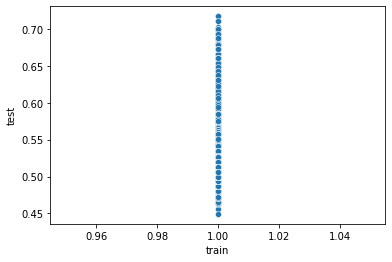

In [224]:
import seaborn as sns
sns.scatterplot(x='train',y='test', data=df)